In [ ]:
!pip install crepes==0.1.0 pyDVL

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.5 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.insert(0, "../")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from src.utils import *
from src.dataloader import *
from triage.triage import Triage


In [ ]:
df, _, _ = load_seer_cutract_dataset(name="seer", seed=42)

cols = df.columns

In [ ]:
def evaluate_methods(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed):
    from sklearn.metrics import mean_absolute_error as reg_metric
    from sklearn.metrics import mean_squared_error as reg_metric_mse
    from sklearn.linear_model import  LinearRegression

    results = {}
    results_mse = {}

    ######
    myids = we_ids
    keep = len(myids)

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[myids,:], y_prop_train[myids])

    y_pred = learner_prop.predict(X_test)

    results['TRIAGE'] = reg_metric(y_test, y_pred)
    results_mse['TRIAGE'] = reg_metric_mse(y_test, y_pred)

    return results, results_mse

### KNN Valuation

In [ ]:
from pydvl.value import *
from pydvl.utils import Dataset

def evaluate_dv(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed, method = 'knn_shap', n_keep=100):
    from sklearn.metrics import mean_absolute_error as reg_metric
    from sklearn.metrics import mean_squared_error as reg_metric_mse
    from sklearn.linear_model import  LinearRegression
    import xgboost as xgb

    train_ids = random.sample(list(range(len(y_prop_train))),int(1*len(y_prop_train)))
    y_prop_train = y_prop_train[train_ids]
    X_prop_train = X_prop_train[train_ids,:]


    X_prop_train = np.array(X_prop_train)
    y_prop_train = np.array(y_prop_train)
    X_cal = np.array(X_cal)
    y_cal = np.array(y_cal)

    dataset = Dataset(X_prop_train, y_prop_train, X_cal, y_cal)

    model = xgb.XGBRegressor(n_estimators=10, random_state=seed)

    # KNN-SHAPLEY
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=5)
    utility = Utility(knn, data=dataset)

    values = compute_shapley_values(utility, mode=ShapleyMode.KNN, progress=True)

    myids = we_ids
    keep = n_keep

    values.sort(key="value")
    keeplow = values.indices[0:keep]
    keephigh = values.indices[-keep:]

    results = {}
    results_mse = {}
    print('DV...')
    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[keeplow,:], y_prop_train[keeplow])
    y_pred = learner_prop.predict(X_test)
    results[f'{method}_low'] = reg_metric(y_test, y_pred)
    results_mse[f'{method}_low'] = reg_metric_mse(y_test, y_pred)

    learner_prop = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
    learner_prop.fit(X_prop_train[keephigh,:], y_prop_train[keephigh])
    y_pred = learner_prop.predict(X_test)
    results[f'{method}_high'] = reg_metric(y_test, y_pred)
    results_mse[f'{method}_high'] = reg_metric_mse(y_test, y_pred)

    return results, results_mse

In [ ]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt #for plotting

from tqdm import tqdm

from copy import deepcopy
import random
import time
import xgboost as xgb
from tqdm import tqdm
full_results = {}
full_results_mse = {}

full_shap_results = {}
full_shap_results_mse = {}


cal_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3,  0.4,0.5]
n_runs = 1

full_triage_time = {}
full_shap_time = {}
for cal_size in tqdm(cal_list):
    print("--------------------------------")
    print(f"Running cal size = {cal_size}")
    print("--------------------------------")
    final_results = []
    final_results_mse = []

    final_shap_results = []
    final_shap_results_mse = []


    triage_time = []
    shap_time = []
    for i in range(n_runs):

        seed = i *10
        random.seed(seed)

        X_prop_train, y_prop_train, _ = load_seer_cutract_dataset(name="seer", seed=seed)
        train_ids = random.sample(list(range(len(y_prop_train))),int(0.2*len(y_prop_train)))
        y_prop_train = y_prop_train[train_ids]
        X_prop_train = X_prop_train.iloc[train_ids,:]

        X_prop_train = X_prop_train.reset_index(drop=True)
        y_prop_train = y_prop_train.reset_index(drop=True)

        min_y = y_prop_train.min()
        max_y = y_prop_train.max()

        y_prop_train = np.array([(y_prop_train[i]-min_y)/(max_y-min_y) for i in range(len(y_prop_train))])
        y_prop_train = pd.Series(y_prop_train)

        X_eval, y_eval, _ = load_seer_cutract_dataset(name="cutract", seed=seed)

        y_eval = np.array([(y_eval[i]-min_y)/(max_y-min_y) for i in range(len(y_eval))])
        y_eval = pd.Series(y_eval)

        test_ids = random.sample(list(range(len(y_eval))),int(0.5*len(y_eval)))

        X_test, y_test = X_eval.iloc[test_ids,:], y_eval.iloc[test_ids]

        remaining_eval_ids = np.setdiff1d(range(len(y_eval)), test_ids)

        _, X_cal, _, y_cal = train_test_split(X_eval.iloc[remaining_eval_ids,:],
                                              y_eval.iloc[remaining_eval_ids],
                                              test_size=cal_size,
                                             random_state=seed)

        X_prop_train, X_cal, X_test = np.array(X_prop_train), np.array(X_cal), np.array(X_test)
        y_prop_train, y_cal, y_test = np.array(y_prop_train), np.array(y_cal), np.array(y_test)

        prop = 0.1
        num_ids = int(prop*len(y_prop_train))
        last_ids = range(len(y_prop_train))
        y_prop_train_corrupt = deepcopy(y_prop_train)
        corruptids = random.sample(list(last_ids),num_ids)
        for myid in corruptids:
            corruption = (np.random.choice(5, 1)[0]/2)+1
            y_prop_train_corrupt[myid] = y_prop_train_corrupt[myid]*corruption

        start = time.time()

        nest = 10
        learner = xgb.XGBRegressor(n_estimators=nest, random_state=seed)
        learner.fit(X_prop_train, y_prop_train)

        y_eval = y_prop_train
        X_eval = X_prop_train

        triage = Triage(X_eval = X_eval, y_eval = y_eval, X_cal=X_cal, y_cal=y_cal, nest=nest, learner=learner)
        groups_ids, raw_metrics = triage.run()

        triage_array = raw_metrics['score_metric']

        percentile_thresh = 75
        thresh = 0.33
        conf_thresh_low = thresh
        conf_thresh_high = 1 - thresh
        conf_thresh = 0.5

        variability=  np.std(triage_array, axis=-1) 
        confidence = np.mean(triage_array, axis=-1)

        uncert_percentile = np.percentile(variability, percentile_thresh)


        oe_ids = np.where(
            (confidence <= conf_thresh_low)
            & (variability <= np.percentile(variability, percentile_thresh))
        )[0]
        ue_ids = np.where(
            (confidence >= conf_thresh_high)
            & (variability <= np.percentile(variability, percentile_thresh))
        )[0]

        other_ids = np.concatenate((oe_ids, ue_ids))
        we_ids = []
        for id in range(len(confidence)):
            if id not in other_ids:
                we_ids.append(id)

        we_ids = np.array(we_ids)

        end = time.time()
        duration_triage = end-start

        n_keep = len(we_ids)

        results, results_mse = evaluate_methods(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed)
        final_results.append(results)
        final_results_mse.append(results_mse)

        print('running shap...')
        start_shap = time.time()
        results, results_mse = evaluate_dv(X_prop_train, y_prop_train, X_cal, y_cal, X_test, y_test, seed, n_keep = n_keep)
        end_shap = time.time()
        duration_shap = end_shap-start_shap
        final_shap_results.append(results)
        final_shap_results_mse.append(results_mse)

        triage_time.append(duration_triage)
        shap_time.append(duration_shap)

    full_results[cal_size] = final_results
    full_results_mse[cal_size] = final_results_mse

    full_shap_results[cal_size] = final_shap_results
    full_shap_results_mse[cal_size] = final_shap_results_mse

    full_triage_time[cal_size] = triage_time
    full_shap_time[cal_size] = shap_time

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------
Running cal size = 0.01
--------------------------------
running shap...


0it [00:00, ?it/s]

 10%|█         | 1/10 [00:09<01:24,  9.37s/it]

2334 2334
DV...
--------------------------------
Running cal size = 0.02
--------------------------------
running shap...


0it [00:00, ?it/s]

 20%|██        | 2/10 [00:17<01:11,  8.93s/it]

2033 2033
DV...
--------------------------------
Running cal size = 0.03
--------------------------------
running shap...


0it [00:00, ?it/s]

 30%|███       | 3/10 [00:27<01:05,  9.34s/it]

2292 2292
DV...
--------------------------------
Running cal size = 0.04
--------------------------------
running shap...


0it [00:00, ?it/s]

 40%|████      | 4/10 [00:37<00:57,  9.62s/it]

1772 1772
DV...
--------------------------------
Running cal size = 0.05
--------------------------------
running shap...


0it [00:00, ?it/s]

 50%|█████     | 5/10 [00:47<00:48,  9.64s/it]

1607 1607
DV...
--------------------------------
Running cal size = 0.1
--------------------------------
running shap...


0it [00:00, ?it/s]

 60%|██████    | 6/10 [00:57<00:39,  9.76s/it]

1540 1540
DV...
--------------------------------
Running cal size = 0.2
--------------------------------
running shap...


0it [00:00, ?it/s]

 70%|███████   | 7/10 [01:09<00:31, 10.52s/it]

1719 1719
DV...
--------------------------------
Running cal size = 0.3
--------------------------------
running shap...


0it [00:00, ?it/s]

 80%|████████  | 8/10 [01:23<00:22, 11.44s/it]

1552 1552
DV...
--------------------------------
Running cal size = 0.4
--------------------------------
running shap...


0it [00:00, ?it/s]

 90%|█████████ | 9/10 [01:37<00:12, 12.51s/it]

1676 1676
DV...
--------------------------------
Running cal size = 0.5
--------------------------------
running shap...


0it [00:00, ?it/s]

100%|██████████| 10/10 [01:56<00:00, 11.67s/it]

1643 1643
DV...


In [ ]:
full_results_mse

{0.01: [{'TRIAGE': 0.04982916025728409}],
 0.02: [{'TRIAGE': 0.05107930788312179}],
 0.03: [{'TRIAGE': 0.04990393606042868}],
 0.04: [{'TRIAGE': 0.04627260282219849}],
 0.05: [{'TRIAGE': 0.10680377928718386}],
 0.1: [{'TRIAGE': 0.045563133620141326}],
 0.2: [{'TRIAGE': 0.04966826066443067}],
 0.3: [{'TRIAGE': 0.049063235363064936}],
 0.4: [{'TRIAGE': 0.04943301251815702}],
 0.5: [{'TRIAGE': 0.06740358034275283}]}

In [ ]:
full_shap_results_mse


{0.01: [{'knn_shap_low': 0.10249443051427055,
   'knn_shap_high': 0.0915166530375187}],
 0.02: [{'knn_shap_low': 0.0929283964511714,
   'knn_shap_high': 0.0945701060484301}],
 0.03: [{'knn_shap_low': 0.07915920466108833,
   'knn_shap_high': 0.09224169984184198}],
 0.04: [{'knn_shap_low': 0.10430125811759561,
   'knn_shap_high': 0.12225701301354189}],
 0.05: [{'knn_shap_low': 0.12599921966766217,
   'knn_shap_high': 0.11560352043511068}],
 0.1: [{'knn_shap_low': 0.10420637372523911,
   'knn_shap_high': 0.08552075844656283}],
 0.2: [{'knn_shap_low': 0.10867132079103213,
   'knn_shap_high': 0.05379999586322013}],
 0.3: [{'knn_shap_low': 0.09081004287351932,
   'knn_shap_high': 0.07559729957179205}],
 0.4: [{'knn_shap_low': 0.1103483097811651,
   'knn_shap_high': 0.07749767581623945}],
 0.5: [{'knn_shap_low': 0.11803609721103003,
   'knn_shap_high': 0.10371743645951682}]}

In [ ]:
results_type = full_shap_results_mse
models = list(results_type[0.1][0].keys())
props = list(results_type.keys())

from scipy.stats import sem


model_means = {}
model_stds = {}

for model in models:

    model_scores_mean = []
    model_scores_std = []

    for prop in props:

        scores = []

        for result_dict in results_type[prop]:

            scores.append(result_dict[model])

        model_scores_mean.append(np.mean(scores))
        model_scores_std.append(sem(scores))

    model_means[model] = model_scores_mean
    model_stds[model] = model_scores_std

model_means

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'knn_shap_low': [0.10249443051427055,
  0.0929283964511714,
  0.07915920466108833,
  0.10430125811759561,
  0.12599921966766217,
  0.10420637372523911,
  0.10867132079103213,
  0.09081004287351932,
  0.1103483097811651,
  0.11803609721103003],
 'knn_shap_high': [0.0915166530375187,
  0.0945701060484301,
  0.09224169984184198,
  0.12225701301354189,
  0.11560352043511068,
  0.08552075844656283,
  0.05379999586322013,
  0.07559729957179205,
  0.07749767581623945,
  0.10371743645951682]}

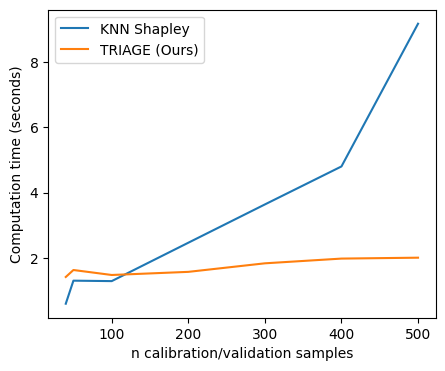

In [ ]:
import matplotlib.pyplot as plt

shap = [np.mean(full_shap_time[key]) for key in full_shap_time.keys()][3:]
triage = [np.mean(full_triage_time[key]) for key in full_triage_time.keys()][3:]
T = np.array(list(full_triage_time.keys()))*1000
T = T[3:]

plt.figure(figsize=(5,4))
plt.plot(T, shap, label= 'KNN Shapley')
plt.plot(T, triage, label= 'TRIAGE (Ours)')
plt.xlabel('n calibration/validation samples')
plt.ylabel('Computation time (seconds)')
plt.legend()
# plt.savefig('time_knn_shap_normal.pdf', bbox_inches="tight")
